In [7]:
%pylab inline
import pandas as pd

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [8]:
seasonal_removal=True

In [9]:
import os

folder="../../../../../sebas/data/air_qual_aemet/"
stations = os.listdir(folder)
stations = pd.Series(stations).apply(lambda e: e.split(".csv")[0]).values

In [30]:
fields=['AEMET.BLH', 'AEMET.SP', 'AEMET.T2M', 'AEMET.TP', 'AEMET.U10',
       'AEMET.V10', 'AEMET.WS', 'AEMET.WD', 'MACC.NO2', 'MACC.O3', 'MACC.PM10',
       'MACC.PM25', 'SPA.NO2', 'SPA.O3', 'SPA.PM10', 'SPA.PM25']

fields=['MACC.NO2', 'MACC.O3', 'MACC.PM10',
       'MACC.PM25', 'SPA.NO2', 'SPA.O3', 'SPA.PM10', 'SPA.PM25']

fields=['SPA.NO2', 'SPA.O3']

fields=['SPA.NO2']

In [31]:
from tqdm.notebook import tqdm

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [33]:
seq_length=168
horizon=13

In [34]:
stations=["28079004"]

  0%|          | 0/1 [00:00<?, ?it/s]

28079004: SPA.NO2


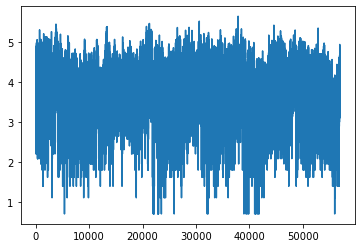

In [35]:
X_train=[]
y_train=[]
for station in tqdm(stations):
    # Reading input file
    df = pd.read_csv(f"{folder}/{station}.csv",sep=";")
    # Limiting Date
    df = df[df["DATE"]<"2020-01-01"]
    for field in fields:
        print(f"{station}: {field}")
        
        tdf = df[["DATE",field]].copy()

        #Stop is there are null values
        if (tdf[field].isnull().sum()>0):
          break

        # Log transform
        tdf[field]=np.log1p(tdf[field])

        plt.plot(tdf[field])
        plt.show()
        if seasonal_removal:
            #STL Decomp
            stl = seasonal_decompose(tdf[field], model="additive",period=24)
            tdf[field]=tdf[field]-stl.seasonal
            # We keep the trend at prediction time:
            # norm_field = field-trend_pred (horizon shifted)
            tdf["trend_norm"]=stl.trend.shift(horizon)
            tdf["seasonal"]=stl.seasonal
        else:
            tdf["trend_norm"]=0
            tdf["seasonal"]=0

        # We remove the trend at prediction time for lagged values
        for h in np.arange(0,horizon+seq_length+1):
            if h>horizon:
                temp = pd.DataFrame()
                temp[f"value - {h}"]=(tdf[field].shift(h)-tdf["trend_norm"]).copy()
                tdf=pd.concat([tdf,temp],axis=1)
        
        # We remove the trend at prediction time 
        # It must be done AFTER creating the lagged values
        tdf[field]=tdf[field]-tdf["trend_norm"]
        tdf=tdf.dropna()

        cols = tdf.columns[tdf.columns.str.contains(f"value -")]
        X = tdf[cols].copy()
        y = tdf[[field]].copy()
        y.columns=["values"]

        TRAIN_SPLIT = tdf[tdf["DATE"]>"2018"].index.values[0]

        X_train.append(X[X.index<=TRAIN_SPLIT].copy())
        y_train.append(y[X.index<=TRAIN_SPLIT].copy())
        
X_train=pd.concat(X_train)
y_train=pd.concat(y_train)

In [36]:
X.shape

(56809, 168)

In [37]:
X_train.shape

(39290, 168)

  0%|          | 0/1 [00:00<?, ?it/s]

28079004: SPA.NO2


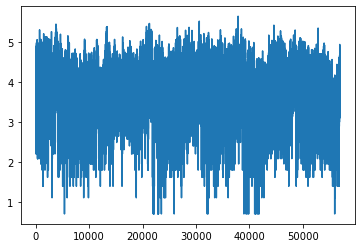

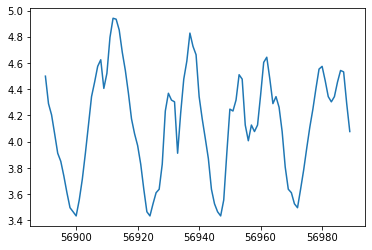

In [38]:
X_test=[]
y_test=[]
v_recover = []
for station in tqdm(["28079004"]):
    # Reading input file
    df = pd.read_csv(f"{folder}/{station}.csv",sep=";")
    # Limiting Date
    df = df[df["DATE"]<"2020-01-01"]
    for field in fields:
        print(f"{station}: {field}")
        
        tdf = df[["DATE",field]].copy()

        #Stop is there are null values
        if (tdf[field].isnull().sum()>0):
          break

        # Log transform
        tdf[field]=np.log1p(tdf[field])

        plt.plot(tdf[field])
        plt.show()
        plt.plot(tdf[field][-100:])
        plt.show()
        if seasonal_removal:
            #STL Decomp
            stl = seasonal_decompose(tdf[field], model="additive",period=24)
            tdf[field]=tdf[field]-stl.seasonal
            # We keep the trend at prediction time:
            # norm_field = field-trend_pred (horizon shifted)
            tdf["trend_norm"]=stl.trend.shift(horizon)
            tdf["seasonal"]=stl.seasonal
        else:
            tdf["trend_norm"]=0
            tdf["seasonal"]=0

        # We remove the trend at prediction time for lagged values
        for h in np.arange(0,horizon+seq_length+1):
            if h>horizon:
                temp = pd.DataFrame()
                temp[f"value - {h}"]=(tdf[field].shift(h)-tdf["trend_norm"]).copy()
                tdf=pd.concat([tdf,temp],axis=1)
        
        # We remove the trend at prediction time 
        # It must be done AFTER creating the lagged values
        tdf[field]=tdf[field]-tdf["trend_norm"]
        tdf=tdf.dropna()

        cols = tdf.columns[tdf.columns.str.contains(f"value -")]
        X = tdf[cols].copy()
        y = tdf[field].copy()
        y.columns=["values"]

        test_SPLIT = tdf[tdf["DATE"]>"2018"].index.values[0]

        X_test.append(X[X.index>test_SPLIT].copy())
        y_test.append(y[X.index>test_SPLIT].copy())
        v_recover.append(tdf[X.index>test_SPLIT][["trend_norm","seasonal"]].copy())
        
X_test=pd.concat(X_test)
y_test=pd.concat(y_test)
v_recover=pd.concat(v_recover)

In [39]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
from torch.utils.data import DataLoader, TensorDataset, random_split

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_everything(42)

X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)
y_train = torch.FloatTensor(y_train.values)
y_test= torch.FloatTensor(y_test.values)

In [40]:
# https://github.com/harryliew/COCOB-optimizer/blob/master/cocob_bp.py

import torch.optim as optim
import torch

###########################################################################
# Training Deep Networks without Learning Rates Through Coin Betting
# Paper: https://arxiv.org/abs/1705.07795
#
# NOTE: This optimizer is hardcoded to run on GPU, needs to be parametrized
###########################################################################

class COCOBBackprop(optim.Optimizer):
    
    def __init__(self, params, alpha=100, epsilon=1e-8):
        
        self._alpha = alpha
        self.epsilon = epsilon
        defaults = dict(alpha=alpha, epsilon=epsilon)
        super(COCOBBackprop, self).__init__(params, defaults)
        
    def step(self, closure=None):
        
        loss = None
        
        if closure is not None:
            loss = closure()
            
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
        
                grad = p.grad.data
                state = self.state[p]
                
                if len(state) == 0:
                    state['gradients_sum'] = torch.zeros_like(p.data).cuda().float()
                    state['grad_norm_sum'] = torch.zeros_like(p.data).cuda().float()
                    state['L'] = self.epsilon * torch.ones_like(p.data).cuda().float()
                    state['tilde_w'] = torch.zeros_like(p.data).cuda().float()
                    state['reward'] = torch.zeros_like(p.data).cuda().float()
                    
                gradients_sum = state['gradients_sum']
                grad_norm_sum = state['grad_norm_sum']
                tilde_w = state['tilde_w']
                L = state['L']
                reward = state['reward']
                
                zero = torch.cuda.FloatTensor([0.])
                
                L_update = torch.max(L, torch.abs(grad))
                gradients_sum_update = gradients_sum + grad
                grad_norm_sum_update = grad_norm_sum + torch.abs(grad)
                reward_update = torch.max(reward - grad * tilde_w, zero)
                new_w = -gradients_sum_update/(L_update * (torch.max(grad_norm_sum_update + L_update, self._alpha * L_update)))*(reward_update + L_update)
                p.data = p.data - tilde_w + new_w
                tilde_w_update = new_w
                
                state['gradients_sum'] = gradients_sum_update
                state['grad_norm_sum'] = grad_norm_sum_update
                state['L'] = L_update
                state['tilde_w'] = tilde_w_update
                state['reward'] = reward_update

        return loss


In [41]:
import pytorch_lightning as pl

class TCN(pl.LightningModule):
    def __init__(self,n_channels=128,k_size=3,regressor_size=200):
        super().__init__()
        
        self.n_channels, self.k_size, self.regressor_size = n_channels, k_size, regressor_size

        self.features = nn.Sequential(
            nn.Conv1d(in_channels=1, 
                      out_channels=self.n_channels, 
                      kernel_size=self.k_size, 
                      padding=(int(self.k_size/2))),
            nn.MaxPool1d(2),
            nn.ReLU(),
        )

        self.regressor = nn.Sequential(
            nn.LayerNorm(self.n_channels*int(seq_length/2)),
            nn.Linear(self.n_channels*int(seq_length/2),self.regressor_size),
            nn.ReLU(),
            nn.LayerNorm(self.regressor_size),
            nn.Linear(self.regressor_size,1)
        )
    
    def forward(self,x):
        x = self.features(x)
        x = x.view(-1,self.n_channels*x.shape[2])
        return self.regressor(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat  = self(x)
        criterion = nn.MSELoss(reduction='sum')
        loss = criterion(y_hat, y)
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_hat  = self(x)
        criterion = nn.MSELoss(reduction='sum')
        loss = criterion(y_hat, y)
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        
    def test_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_hat  = self(x)
        criterion = nn.MSELoss(reduction='sum')
        loss = criterion(y_hat, y)
        # We would have to modify this for better aggregation
        # https://forums.pytorchlightning.ai/t/understanding-logging-and-validation-step-validation-epoch-end/291/2
        self.log("test_loss", loss)
        
    def predict_step(self, batch, batch_idx):
        x, y = batch
        return self(x)
        

    def configure_optimizers(self):
        optimizer = COCOBBackprop(self.parameters())
        return optimizer


In [42]:
# setup data
X_train_gf = X_train.reshape(len(X_train),1,len(X_train[0]))
train = TensorDataset(X_train_gf, y_train)
train, valid = random_split(train,[int(len(train)*0.95), len(train)-int(len(train)*0.95)])
train_loader = DataLoader(train, batch_size=512, shuffle=True,num_workers=8)
valid_loader = DataLoader(valid, batch_size=256,num_workers=8)

In [43]:
from pytorch_lightning.callbacks import EarlyStopping

trainer = pl.Trainer(max_epochs=3,
                     accelerator="gpu",
                     max_time="00:00:10:00",
                     callbacks=[EarlyStopping("val_loss",
                                              verbose=True, 
                                              patience=3,
                                              mode="min")])
tcn=TCN(n_channels=64,k_size=3,regressor_size=200)
trainer.fit(model=tcn, train_dataloaders=train_loader,val_dataloaders=valid_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 256   
1 | regressor | Sequential | 1.1 M 
-----------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.348     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 48.401


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.741 >= min_delta = 0.0. New best score: 46.660


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.479 >= min_delta = 0.0. New best score: 46.181


In [44]:
X_test_gf = X_test.reshape(len(X_test),1,len(X_test[0]))
test = TensorDataset(X_test_gf, y_test)
test_loader = DataLoader(test, batch_size=256, num_workers=8)
trainer.test(tcn,test_loader)[0]["test_loss"]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss              18858.6171875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([111])) that is different to the input size (torch.Size([111, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


18858.6171875

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 73it [00:00, ?it/s]

 Val Loss: 18.560507652305155


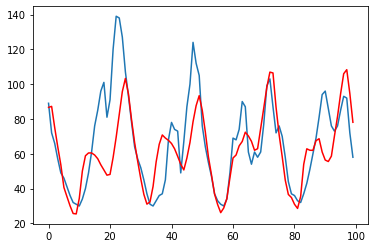

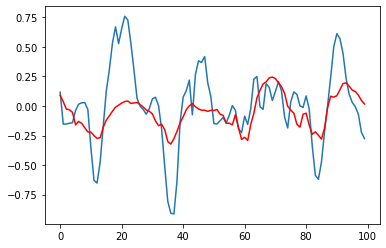

In [45]:
from sklearn.metrics import mean_squared_error

allp=np.array([])
for p in trainer.predict(tcn,test_loader):
    allp = np.concatenate([allp,p.reshape(-1)])
    
# We get the real values
real_y_test = np.expm1(y_test + v_recover["trend_norm"].values + v_recover["seasonal"].values)
real_pred = np.expm1(allp + v_recover["trend_norm"].values + v_recover["seasonal"].values)
real_season = np.expm1(v_recover["trend_norm"].values + v_recover["seasonal"].values)
print(f' Val Loss: {np.sqrt(mean_squared_error(real_y_test,real_pred))}')
    
plt.plot(real_y_test[-100:])
plt.plot(real_pred[-100:],c="red")
#plt.plot(real_season[-100:],c="green")
plt.show()

plt.plot(y_test[-100:])
plt.plot(allp[-100:],c="red")
plt.show()

In [46]:
"""trainer.checkpoint_callback.best_model_path
X_test_gf = X_test.reshape(len(X_test),1,len(X_test[0]))
model = tcn.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
model.freeze()
model = model.eval()"""

'trainer.checkpoint_callback.best_model_path\nX_test_gf = X_test.reshape(len(X_test),1,len(X_test[0]))\nmodel = tcn.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)\nmodel.freeze()\nmodel = model.eval()'

### Parameters:
- Number of channels
- Kernel Size
- Maxpool size
- Batch Size
- Epochs
- Regressor:
    - Size
    - Number of hidden layers

In [220]:
from ConfigSpace import ConfigurationSpace
from ConfigSpace.hyperparameters import UniformIntegerHyperparameter
from smac.facade.smac_bb_facade import SMAC4BB
from smac.scenario.scenario import Scenario

In [232]:
def train_model(config):
    
    batch_size = config["batch_size"]
    epochs = config["epochs"]
    n_channels= config["n_channels"]
    ksize = config["ksize"]
    regressor_size= config["regressor_size"]

    # Setup data
    X_train_gf = X_train.reshape(len(X_train),1,len(X_train[0]))
    train = TensorDataset(X_train_gf, y_train)
    train, valid = random_split(train,[int(len(train)*0.95), len(train)-int(len(train)*0.95)])
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True,num_workers=8)
    valid_loader = DataLoader(valid, batch_size=256)

    from pytorch_lightning.callbacks import EarlyStopping

    trainer = pl.Trainer(max_epochs=epochs,
                         accelerator="gpu",
                         max_time="00:00:20:00",
                         callbacks=[EarlyStopping("val_loss",
                                                  verbose=True, 
                                                  patience=3,
                                                  mode="min")])

    tcn=TCN(n_channels=n_channels,k_size=ksize,regressor_size=regressor_size)
    trainer.fit(model=tcn, train_dataloaders=train_loader,val_dataloaders=valid_loader)

    X_test_gf = X_test.reshape(len(X_test),1,len(X_test[0]))
    test = TensorDataset(X_test_gf, y_test)
    test_loader = DataLoader(test, batch_size=256, num_workers=8)

    return trainer.test(tcn,test_loader)[0]["test_loss"]

In [233]:
# Define your hyperparameters
configspace = ConfigurationSpace()
configspace.add_hyperparameter(UniformIntegerHyperparameter("batch_size", 30, 4000))
configspace.add_hyperparameter(UniformIntegerHyperparameter("epochs", 2, 20))
configspace.add_hyperparameter(UniformIntegerHyperparameter("n_channels", 8, 256))
configspace.add_hyperparameter(UniformIntegerHyperparameter("ksize", 3, 20))
configspace.add_hyperparameter(UniformIntegerHyperparameter("regressor_size", 50, 1000))

# Provide meta data for the optimization
scenario = Scenario({
    "run_obj": "quality",  
    "runcount-limit": 100,  
    "cs": configspace,
})

smac = SMAC4BB(scenario=scenario, tae_runner=train_model)
best_found_config = smac.optimize()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.4 K 
1 | regressor | Sequential | 6.0 M 
-----------------------------------------
6.0 M     Trainable params
0         Non-trainable params
6.0 M     Total params
23.895    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 97.357


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 9.474 >= min_delta = 0.0. New best score: 87.883
Time limit reached. Elapsed time is 0:01:02. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.566 >= min_delta = 0.0. New best score: 87.317
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            71.47102355957031
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 845   
1 | regressor | Sequential | 2.4 M 
-----------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.773     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 88.665
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.566 >= min_delta = 0.0. New best score: 85.099
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            70.27510833740234
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.7 K 
1 | regressor | Sequential | 5.8 M 
-----------------------------------------
5.8 M     Trainable params
0         Non-trainable params
5.8 M     Total params
23.389    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 92.218
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.024 >= min_delta = 0.0. New best score: 89.194
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            74.10700225830078
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 578   
1 | regressor | Sequential | 1.4 M 
-----------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.619     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 91.141


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 6.591 >= min_delta = 0.0. New best score: 84.550
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            70.05371856689453
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 2.9 K 
1 | regressor | Sequential | 11.2 M
-----------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.784    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 99.347
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            84.6055908203125
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.6 K 
1 | regressor | Sequential | 14.1 M
-----------------------------------------
14.1 M    Trainable params
0         Non-trainable params
14.1 M    Total params
56.391    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 93.627
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            91.29212188720703
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 854   
1 | regressor | Sequential | 1.7 M 
-----------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.608     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 83.719
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.1 K 
1 | regressor | Sequential | 2.0 M 
-----------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.927     Total estimated model params size (MB)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            71.49589538574219
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 89.097
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.706 >= min_delta = 0.0. New best score: 87.391
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            71.65825653076172
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 2.2 K 
1 | regressor | Sequential | 8.2 M 
-----------------------------------------
8.2 M     Trainable params
0         Non-trainable params
8.2 M     Total params
32.696    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 107.826
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 7.394 >= min_delta = 0.0. New best score: 100.432
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            80.29241180419922
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 440   
1 | regressor | Sequential | 880 K 
-----------------------------------------
881 K     Trainable params
0         Non-trainable params
881 K     Total params
3.524     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 103.016


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 14.155 >= min_delta = 0.0. New best score: 88.861


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.891 >= min_delta = 0.0. New best score: 85.970
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            70.18975067138672
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 4.1 K 
1 | regressor | Sequential | 13.3 M
-----------------------------------------
13.3 M    Trainable params
0         Non-trainable params
13.3 M    Total params
53.256    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 101.393
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            78.6856460571289
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 708   
1 | regressor | Sequential | 6.1 M 
-----------------------------------------
6.1 M     Trainable params
0         Non-trainable params
6.1 M     Total params
24.357    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 84.282
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            69.59236145019531
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 2.2 K 
1 | regressor | Sequential | 5.6 M 
-----------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.240    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 103.658
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 8.483 >= min_delta = 0.0. New best score: 95.175
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            75.66376495361328
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 3.5 K 
1 | regressor | Sequential | 6.0 M 
-----------------------------------------
6.0 M     Trainable params
0         Non-trainable params
6.0 M     Total params
23.939    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 116.167
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 10.251 >= min_delta = 0.0. New best score: 105.916
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            81.11502838134766
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.1 K 
1 | regressor | Sequential | 5.6 M 
-----------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.472    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 87.460
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.895 >= min_delta = 0.0. New best score: 86.565
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            70.75558471679688
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 3.4 K 
1 | regressor | Sequential | 19.0 M
-----------------------------------------
19.0 M    Trainable params
0         Non-trainable params
19.0 M    Total params
76.041    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 106.157
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            85.19066619873047
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 85    
1 | regressor | Sequential | 141 K 
-----------------------------------------
141 K     Trainable params
0         Non-trainable params
141 K     Total params
0.567     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 95.505


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.806 >= min_delta = 0.0. New best score: 91.699


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.398 >= min_delta = 0.0. New best score: 86.301


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.489 >= min_delta = 0.0. New best score: 85.813


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.313 >= min_delta = 0.0. New best score: 85.499


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.200 >= min_delta = 0.0. New best score: 84.299
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            69.64605712890625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 2.7 K 
1 | regressor | Sequential | 6.5 M 
-----------------------------------------
6.5 M     Trainable params
0         Non-trainable params
6.5 M     Total params
25.850    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 110.349
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.883 >= min_delta = 0.0. New best score: 104.466
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            82.02005004882812
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 981   
1 | regressor | Sequential | 4.8 M 
-----------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.167    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 88.668
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.543 >= min_delta = 0.0. New best score: 86.125
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            70.22019958496094
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 3.0 K 
1 | regressor | Sequential | 3.7 M 
-----------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.748    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 86.304
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            76.45932006835938
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 396   
1 | regressor | Sequential | 4.8 M 
-----------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.242    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 111.002


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 11.197 >= min_delta = 0.0. New best score: 99.805
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 7.524 >= min_delta = 0.0. New best score: 92.280
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            75.95025634765625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 253   
1 | regressor | Sequential | 1.8 M 
-----------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.002     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 102.719


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.713 >= min_delta = 0.0. New best score: 99.006


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.662 >= min_delta = 0.0. New best score: 95.344


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 6.052 >= min_delta = 0.0. New best score: 89.292
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            87.6562271118164
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 4.8 K 
1 | regressor | Sequential | 2.8 M 
-----------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.193    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 91.916
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            78.14926147460938
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 370   
1 | regressor | Sequential | 1.8 M 
-----------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.192     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 91.348


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.591 >= min_delta = 0.0. New best score: 86.757


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.492 >= min_delta = 0.0. New best score: 86.264
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            70.61565399169922
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 2.6 K 
1 | regressor | Sequential | 10.6 M
-----------------------------------------
10.6 M    Trainable params
0         Non-trainable params
10.6 M    Total params
42.482    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 95.274
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            79.16441345214844
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 944   
1 | regressor | Sequential | 9.0 M 
-----------------------------------------
9.0 M     Trainable params
0         Non-trainable params
9.0 M     Total params
36.091    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 91.700
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            76.61874389648438
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 102   
1 | regressor | Sequential | 144 K 
-----------------------------------------
144 K     Trainable params
0         Non-trainable params
144 K     Total params
0.579     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 90.971


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.999 >= min_delta = 0.0. New best score: 85.972


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.102 >= min_delta = 0.0. New best score: 84.870


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.882 >= min_delta = 0.0. New best score: 83.988


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.760 >= min_delta = 0.0. New best score: 83.228


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.376 >= min_delta = 0.0. New best score: 82.852
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 370   
1 | regressor | Sequential | 621 K 
-----------------------------------------
622 K     Trainable params
0         Non-trainable params
622 K     Total params
2.489     Total estimated model params size (MB)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            69.5497055053711
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 91.900


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.645 >= min_delta = 0.0. New best score: 87.255


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.744 >= min_delta = 0.0. New best score: 86.511
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.527 >= min_delta = 0.0. New best score: 85.984
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            70.19737243652344
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 264   
1 | regressor | Sequential | 366 K 
-----------------------------------------
366 K     Trainable params
0         Non-trainable params
366 K     Total params
1.466     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 100.672


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 14.627 >= min_delta = 0.0. New best score: 86.045


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.684 >= min_delta = 0.0. New best score: 84.361


Validation: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.243 >= min_delta = 0.0. New best score: 84.119
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

CUDA out of memory. Tried to allocate 2.41 GiB (GPU 0; 5.93 GiB total capacity; 73.48 MiB already allocated; 2.41 GiB free; 2.04 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Traceback (most recent call last):
  File "/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/smac/tae/execute_func.py", line 217, in run
    rval = self._call_ta(self._ta, config, obj_kwargs)
  File "/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/smac/tae/execute_func.py", line 314, in _call_ta
    return obj(config, **obj_kwargs)
  File "/tmp/ipykernel_9398/2548141907.py", line 33, in train_model
    return trainer.test(tcn,test_loader)[0]["test_loss"]
  File "/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 936, in test
    return self._call_and_handle_interrupt(self._test_impl, mod

Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 89.714


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.051 >= min_delta = 0.0. New best score: 85.663


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss             72.537841796875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.8 K 
1 | regressor | Sequential | 6.4 M 
-----------------------------------------
6.4 M     Trainable params
0         Non-trainable params
6.4 M     Total params
25.794    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 94.709
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 6.711 >= min_delta = 0.0. New best score: 87.997
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            71.39736938476562
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 48    
1 | regressor | Sequential | 68.9 K
-----------------------------------------
69.0 K    Trainable params
0         Non-trainable params
69.0 K    Total params
0.276     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 95.959


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 7.061 >= min_delta = 0.0. New best score: 88.898


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.013 >= min_delta = 0.0. New best score: 86.885


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.079 >= min_delta = 0.0. New best score: 85.807


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.206 >= min_delta = 0.0. New best score: 85.601


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.085 >= min_delta = 0.0. New best score: 85.516
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 85.488
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            70.52558135986328
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 440   
1 | regressor | Sequential | 761 K 
-----------------------------------------
762 K     Trainable params
0         Non-trainable params
762 K     Total params
3.049     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 111.301


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 23.261 >= min_delta = 0.0. New best score: 88.040


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.978 >= min_delta = 0.0. New best score: 85.062
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.414 >= min_delta = 0.0. New best score: 84.647
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            69.78314208984375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.4 K 
1 | regressor | Sequential | 4.9 M 
-----------------------------------------
4.9 M     Trainable params
0         Non-trainable params
4.9 M     Total params
19.492    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 92.875
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            79.58326721191406
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.1 K 
1 | regressor | Sequential | 2.0 M 
-----------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.908     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 90.386
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            76.7138442993164
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 3.6 K 
1 | regressor | Sequential | 2.4 M 
-----------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.542     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 86.533
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            71.01908111572266
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.1 K 
1 | regressor | Sequential | 5.6 M 
-----------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.414    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 100.178
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 13.693 >= min_delta = 0.0. New best score: 86.485
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            70.0997085571289
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 540   
1 | regressor | Sequential | 1.2 M 
-----------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.967     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 97.400


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 6.831 >= min_delta = 0.0. New best score: 90.570
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            73.00856018066406
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 420   
1 | regressor | Sequential | 4.2 M 
-----------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.776    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 93.931


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 7.138 >= min_delta = 0.0. New best score: 86.792
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            75.69034576416016
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.1 K 
1 | regressor | Sequential | 5.2 M 
-----------------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.707    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 93.830


Validation: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 7.003 >= min_delta = 0.0. New best score: 86.827
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            71.22309112548828
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.3 K 
1 | regressor | Sequential | 2.5 M 
-----------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.015    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 87.031
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            71.49895477294922
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.1 K 
1 | regressor | Sequential | 5.6 M 
-----------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.307    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 112.259


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 18.783 >= min_delta = 0.0. New best score: 93.476
Time limit reached. Elapsed time is 0:01:02. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.507 >= min_delta = 0.0. New best score: 92.969
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            75.5404052734375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 492   
1 | regressor | Sequential | 6.9 M 
-----------------------------------------
6.9 M     Trainable params
0         Non-trainable params
6.9 M     Total params
27.625    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 104.118


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.289 >= min_delta = 0.0. New best score: 101.829
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            88.36958312988281
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 534   
1 | regressor | Sequential | 1.3 M 
-----------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.059     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 96.032


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 8.621 >= min_delta = 0.0. New best score: 87.411
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            72.53974151611328
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 160   
1 | regressor | Sequential | 434 K 
-----------------------------------------
434 K     Trainable params
0         Non-trainable params
434 K     Total params
1.737     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 100.081


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.268 >= min_delta = 0.0. New best score: 94.814
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            78.79910278320312
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.6 K 
1 | regressor | Sequential | 5.9 M 
-----------------------------------------
5.9 M     Trainable params
0         Non-trainable params
5.9 M     Total params
23.751    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 97.605
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 7.499 >= min_delta = 0.0. New best score: 90.106
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss               72.9609375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 270   
1 | regressor | Sequential | 946 K 
-----------------------------------------
946 K     Trainable params
0         Non-trainable params
946 K     Total params
3.787     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 94.896


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.247 >= min_delta = 0.0. New best score: 89.648


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.553 >= min_delta = 0.0. New best score: 86.096


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.849 >= min_delta = 0.0. New best score: 85.247


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.582 >= min_delta = 0.0. New best score: 84.665
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            69.32306671142578
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 2.8 K 
1 | regressor | Sequential | 2.5 M 
-----------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.876     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 96.105
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            89.70281982421875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.7 K 
1 | regressor | Sequential | 13.8 M
-----------------------------------------
13.8 M    Trainable params
0         Non-trainable params
13.8 M    Total params
55.115    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 96.256
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            87.12527465820312
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 4.4 K 
1 | regressor | Sequential | 2.6 M 
-----------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.477    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 95.495
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.344 >= min_delta = 0.0. New best score: 90.150
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            72.4241714477539
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 2.5 K 
1 | regressor | Sequential | 14.1 M
-----------------------------------------
14.1 M    Trainable params
0         Non-trainable params
14.1 M    Total params
56.395    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 100.527
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            79.13014221191406
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 824   
1 | regressor | Sequential | 5.9 M 
-----------------------------------------
5.9 M     Trainable params
0         Non-trainable params
5.9 M     Total params
23.681    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 86.627
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            71.32984924316406
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 459   
1 | regressor | Sequential | 608 K 
-----------------------------------------
609 K     Trainable params
0         Non-trainable params
609 K     Total params
2.437     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 108.537


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 12.775 >= min_delta = 0.0. New best score: 95.762
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            76.7000961303711
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 55    
1 | regressor | Sequential | 615 K 
-----------------------------------------
615 K     Trainable params
0         Non-trainable params
615 K     Total params
2.461     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 96.569


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 8.153 >= min_delta = 0.0. New best score: 88.416


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.860 >= min_delta = 0.0. New best score: 86.556
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            71.02510070800781
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 3.3 K 
1 | regressor | Sequential | 1.3 M 
-----------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.144     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 97.195
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 10.406 >= min_delta = 0.0. New best score: 86.789
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            71.60111236572266
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 140   
1 | regressor | Sequential | 1.1 M 
-----------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.275     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 91.842


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.137 >= min_delta = 0.0. New best score: 86.705
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss             70.809326171875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 284   
1 | regressor | Sequential | 6.0 M 
-----------------------------------------
6.0 M     Trainable params
0         Non-trainable params
6.0 M     Total params
23.921    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 91.137
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            73.24592590332031
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.0 K 
1 | regressor | Sequential | 760 K 
-----------------------------------------
761 K     Trainable params
0         Non-trainable params
761 K     Total params
3.048     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 96.724


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 8.456 >= min_delta = 0.0. New best score: 88.268


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.177 >= min_delta = 0.0. New best score: 86.091


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.088 >= min_delta = 0.0. New best score: 84.003
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            72.38249206542969
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 783   
1 | regressor | Sequential | 4.5 M 
-----------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.874    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 87.821


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.931 >= min_delta = 0.0. New best score: 83.890
Time limit reached. Elapsed time is 0:01:01. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            69.12316131591797
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 414   
1 | regressor | Sequential | 685 K 
-----------------------------------------
685 K     Trainable params
0         Non-trainable params
685 K     Total params
2.743     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 102.741


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 7.136 >= min_delta = 0.0. New best score: 95.605


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 7.493 >= min_delta = 0.0. New best score: 88.112


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.414 >= min_delta = 0.0. New best score: 87.698


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.746 >= min_delta = 0.0. New best score: 84.953


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.843 >= min_delta = 0.0. New best score: 84.109
Time limit reached. Elapsed time is 0:01:01. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.331 >= min_delta = 0.0. New best score: 83.778
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            69.83438873291016
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.2 K 
1 | regressor | Sequential | 1.0 M 
-----------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.126     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 96.619


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 8.258 >= min_delta = 0.0. New best score: 88.362


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.963 >= min_delta = 0.0. New best score: 86.399
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            73.24375915527344
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 252   
1 | regressor | Sequential | 509 K 
-----------------------------------------
509 K     Trainable params
0         Non-trainable params
509 K     Total params
2.037     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 112.198


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 14.450 >= min_delta = 0.0. New best score: 97.748


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.166 >= min_delta = 0.0. New best score: 97.582


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 7.346 >= min_delta = 0.0. New best score: 90.236


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.528 >= min_delta = 0.0. New best score: 87.708


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 87.664


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.673 >= min_delta = 0.0. New best score: 85.992
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.275 >= min_delta = 0.0. New best score: 85.717
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            69.94390106201172
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 808   
1 | regressor | Sequential | 16.1 M
-----------------------------------------
16.1 M    Trainable params
0         Non-trainable params
16.1 M    Total params
64.293    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 91.810
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            75.71288299560547
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.3 K 
1 | regressor | Sequential | 2.0 M 
-----------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.830     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 85.101
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss             69.308349609375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 676   
1 | regressor | Sequential | 2.5 M 
-----------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.829     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 87.458
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            78.8604965209961
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 744   
1 | regressor | Sequential | 2.0 M 
-----------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.817     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 85.060
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            69.71184539794922
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 3.4 K 
1 | regressor | Sequential | 2.8 M 
-----------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.024    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 85.524
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            70.93606567382812
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 4.6 K 
1 | regressor | Sequential | 2.7 M 
-----------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.925    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 88.192
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            71.12963104248047
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.8 K 
1 | regressor | Sequential | 2.6 M 
-----------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.420    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 97.247


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 7.345 >= min_delta = 0.0. New best score: 89.902
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            72.83442687988281
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 3.1 K 
1 | regressor | Sequential | 7.6 M 
-----------------------------------------
7.6 M     Trainable params
0         Non-trainable params
7.6 M     Total params
30.423    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 92.440
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.945 >= min_delta = 0.0. New best score: 91.496
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            74.48848724365234
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 2.2 K 
1 | regressor | Sequential | 2.9 M 
-----------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.639    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 103.205


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 8.585 >= min_delta = 0.0. New best score: 94.619
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            92.27144622802734
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.1 K 
1 | regressor | Sequential | 3.4 M 
-----------------------------------------
3.4 M     Trainable params
0         Non-trainable params
3.4 M     Total params
13.488    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 104.518


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 10.894 >= min_delta = 0.0. New best score: 93.624


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.856 >= min_delta = 0.0. New best score: 89.768
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            83.02727508544922
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 585   
1 | regressor | Sequential | 4.8 M 
-----------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.312    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 88.701


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.485 >= min_delta = 0.0. New best score: 85.215
Time limit reached. Elapsed time is 0:01:01. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 85.199
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            70.16525268554688
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 2.5 K 
1 | regressor | Sequential | 1.1 M 
-----------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.568     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 93.556


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.459 >= min_delta = 0.0. New best score: 88.097
Time limit reached. Elapsed time is 0:01:01. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.348 >= min_delta = 0.0. New best score: 87.749
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            71.22550201416016
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.0 K 
1 | regressor | Sequential | 21.2 M
-----------------------------------------
21.2 M    Trainable params
0         Non-trainable params
21.2 M    Total params
84.861    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 90.147
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            75.97174835205078
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 762   
1 | regressor | Sequential | 7.0 M 
-----------------------------------------
7.0 M     Trainable params
0         Non-trainable params
7.0 M     Total params
28.049    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 86.345
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            72.09907531738281
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 624   
1 | regressor | Sequential | 13.1 M
-----------------------------------------
13.1 M    Trainable params
0         Non-trainable params
13.1 M    Total params
52.539    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 88.351
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            72.81380462646484
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 3.0 K 
1 | regressor | Sequential | 12.0 M
-----------------------------------------
12.0 M    Trainable params
0         Non-trainable params
12.0 M    Total params
48.124    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 88.948
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            71.99884033203125
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 548   
1 | regressor | Sequential | 3.1 M 
-----------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.573    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 91.992


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.906 >= min_delta = 0.0. New best score: 86.086
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            73.20755004882812
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 5.4 K 
1 | regressor | Sequential | 1.1 M 
-----------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.495     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 103.781
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.872 >= min_delta = 0.0. New best score: 100.909
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss              76.9716796875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.0 K 
1 | regressor | Sequential | 214 K 
-----------------------------------------
215 K     Trainable params
0         Non-trainable params
215 K     Total params
0.861     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 95.560


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.910 >= min_delta = 0.0. New best score: 91.650


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.945 >= min_delta = 0.0. New best score: 86.705


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.514 >= min_delta = 0.0. New best score: 85.191
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            69.83577728271484
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 104   
1 | regressor | Sequential | 1.8 M 
-----------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.370     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 92.095


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 6.703 >= min_delta = 0.0. New best score: 85.393
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            70.17247772216797
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 4.7 K 
1 | regressor | Sequential | 21.0 M
-----------------------------------------
21.0 M    Trainable params
0         Non-trainable params
21.0 M    Total params
83.866    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 116.315
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            88.06330108642578
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 2.2 K 
1 | regressor | Sequential | 450 K 
-----------------------------------------
452 K     Trainable params
0         Non-trainable params
452 K     Total params
1.809     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 106.443


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 9.706 >= min_delta = 0.0. New best score: 96.736
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            78.7157211303711
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 160   
1 | regressor | Sequential | 1.1 M 
-----------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.487     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 94.615


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4.591 >= min_delta = 0.0. New best score: 90.025


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.555 >= min_delta = 0.0. New best score: 87.470


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.157 >= min_delta = 0.0. New best score: 86.313
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            70.07628631591797
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 3.6 K 
1 | regressor | Sequential | 14.3 M
-----------------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
57.265    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 94.191
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            75.90105438232422
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 2.6 K 
1 | regressor | Sequential | 543 K 
-----------------------------------------
545 K     Trainable params
0         Non-trainable params
545 K     Total params
2.184     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 113.914


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 9.861 >= min_delta = 0.0. New best score: 104.053
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.297 >= min_delta = 0.0. New best score: 101.755
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            81.04395294189453
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 4.5 K 
1 | regressor | Sequential | 952 K 
-----------------------------------------
957 K     Trainable params
0         Non-trainable params
957 K     Total params
3.830     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 119.606
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 15.311 >= min_delta = 0.0. New best score: 104.295
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            86.7773666381836
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 360   
1 | regressor | Sequential | 398 K 
-----------------------------------------
398 K     Trainable params
0         Non-trainable params
398 K     Total params
1.595     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 94.178


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.908 >= min_delta = 0.0. New best score: 88.270
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            71.03008270263672
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 564   
1 | regressor | Sequential | 11.9 M
-----------------------------------------
11.9 M    Trainable params
0         Non-trainable params
11.9 M    Total params
47.442    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 114.925
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 17.604 >= min_delta = 0.0. New best score: 97.322
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            78.2575454711914
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.2 K 
1 | regressor | Sequential | 20.2 M
-----------------------------------------
20.2 M    Trainable params
0         Non-trainable params
20.2 M    Total params
80.822    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 95.171
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            77.59725952148438
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 5.4 K 
1 | regressor | Sequential | 21.6 M
-----------------------------------------
21.6 M    Trainable params
0         Non-trainable params
21.6 M    Total params
86.226    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

CUDA out of memory. Tried to allocate 660.00 MiB (GPU 0; 5.93 GiB total capacity; 2.23 GiB already allocated; 557.69 MiB free; 3.97 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
Traceback (most recent call last):
  File "/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/smac/tae/execute_func.py", line 217, in run
    rval = self._call_ta(self._ta, config, obj_kwargs)
  File "/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/smac/tae/execute_func.py", line 314, in _call_ta
    return obj(config, **obj_kwargs)
  File "/tmp/ipykernel_9398/2548141907.py", line 27, in train_model
    trainer.fit(model=tcn, train_dataloaders=train_loader,val_dataloaders=valid_loader)
  File "/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py", line 768, in fit
    self._call_and_handle_inte

Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 91.314
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            74.7702865600586
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 3.4 K 
1 | regressor | Sequential | 2.9 M 
-----------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.643    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 99.934
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.171 >= min_delta = 0.0. New best score: 99.763
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            79.09026336669922
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 904   
1 | regressor | Sequential | 17.3 M
-----------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.120    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 87.813
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            71.36607360839844
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 1.0 K 
1 | regressor | Sequential | 1.1 M 
-----------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.478     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 89.013
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            74.26536560058594
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 944   
1 | regressor | Sequential | 1.0 M 
-----------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.128     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 87.122
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            71.39520263671875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 764   
1 | regressor | Sequential | 834 K 
-----------------------------------------
835 K     Trainable params
0         Non-trainable params
835 K     Total params
3.341     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 97.517


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 9.661 >= min_delta = 0.0. New best score: 87.857
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            72.98136901855469
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 4.4 K 
1 | regressor | Sequential | 939 K 
-----------------------------------------
944 K     Trainable params
0         Non-trainable params
944 K     Total params
3.776     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 109.561
Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 6.605 >= min_delta = 0.0. New best score: 102.956
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            80.67743682861328
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 4.6 K 
1 | regressor | Sequential | 956 K 
-----------------------------------------
961 K     Trainable params
0         Non-trainable params
961 K     Total params
3.846     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Time limit reached. Elapsed time is 0:01:00. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 91.118
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            74.03682708740234
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [234]:
best_found_config

Configuration(values={
  'batch_size': 1347,
  'epochs': 3,
  'ksize': 8,
  'n_channels': 87,
  'regressor_size': 609,
})

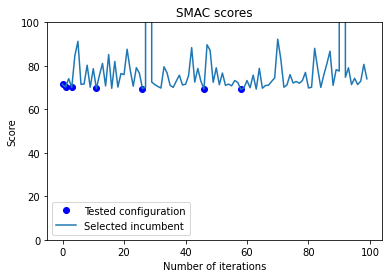

In [239]:
cfg_traj = [ traj.incumbent for traj in smac.trajectory]
plt.plot([smac.runhistory.get_cost(cfg) if cfg in cfg_traj else None for cfg in smac.runhistory.get_all_configs()], 'bo')
plt.plot([smac.runhistory.get_cost(cfg)  for cfg in  smac.runhistory.get_all_configs()])
plt.title('SMAC scores')
plt.legend(['Tested configuration', 'Selected incumbent'])
plt.xlabel('Number of iterations')
plt.ylim([0,100])
plt.ylabel('Score')
plt.show()

In [240]:
config={
  'batch_size': 1347,
  'epochs': 20,
  'ksize': 8,
  'n_channels': 87,
  'regressor_size': 609,
}

batch_size = config["batch_size"]
epochs = config["epochs"]
n_channels= config["n_channels"]
ksize = config["ksize"]
regressor_size= config["regressor_size"]

# Setup data
X_train_gf = X_train.reshape(len(X_train),1,len(X_train[0]))
train = TensorDataset(X_train_gf, y_train)
train, valid = random_split(train,[int(len(train)*0.95), len(train)-int(len(train)*0.95)])
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True,num_workers=8)
valid_loader = DataLoader(valid, batch_size=256)

from pytorch_lightning.callbacks import EarlyStopping

trainer = pl.Trainer(max_epochs=epochs,
                     accelerator="gpu",
                     max_time="00:01:00:00",
                     callbacks=[EarlyStopping("val_loss",
                                              verbose=True, 
                                              patience=3,
                                              mode="min")])

tcn=TCN(n_channels=n_channels,k_size=ksize,regressor_size=regressor_size)
trainer.fit(model=tcn, train_dataloaders=train_loader,val_dataloaders=valid_loader)

X_test_gf = X_test.reshape(len(X_test),1,len(X_test[0]))
test = TensorDataset(X_test_gf, y_test)
test_loader = DataLoader(test, batch_size=256, num_workers=8)

trainer.test(tcn,test_loader)[0]["test_loss"]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | features  | Sequential | 783   
1 | regressor | Sequential | 4.5 M 
-----------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.874    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/sebas/miniconda3/envs/phd/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 89.906


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 6.081 >= min_delta = 0.0. New best score: 83.825


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.267 >= min_delta = 0.0. New best score: 82.558


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.494 >= min_delta = 0.0. New best score: 82.065


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.357 >= min_delta = 0.0. New best score: 81.708


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.228 >= min_delta = 0.0. New best score: 81.480


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.506 >= min_delta = 0.0. New best score: 80.974


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.202 >= min_delta = 0.0. New best score: 80.772


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 80.727


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.432 >= min_delta = 0.0. New best score: 80.295


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 80.295. Signaling Trainer to stop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            68.40650939941406
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


68.40650939941406

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 665it [00:00, ?it/s]

 Val Loss: 0.5173840297344291


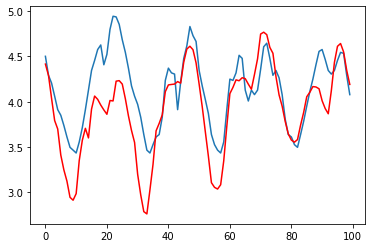

In [242]:
from sklearn.metrics import mean_squared_error

allp=np.array([])
for p in trainer.predict(tcn,test_loader):
    allp = np.concatenate([allp,p.reshape(-1)])
print(f' Val Loss: {np.sqrt(mean_squared_error(allp,y_test))}')
    
plt.plot(y_test.cpu()[-100:])
plt.plot(allp[-100:],c="red")
plt.show()